The goal of this notebook is to generalize the `aftereburner` function that is needed to run the denoising algorithm over patches of the full FVC image and then stitches these denoised patches together to create the fully denoised FVC image.

The high level idea behind the afterburner function is to denoise patches



~(2000x2000) image patches of the larger (6000,6000) FVC image. The reason I put ~(2000x2000) is because the previous iteration of the afterburner function didn't attenuate the artifacts that are caused by non-overlapping inference patches. The actual size of the patches will be (2020x2020), so that can run inference over the entire patch and throw away the border without having any problems with 

# **THIS NOTEBOOK USES THE UPDATED TORCH AFTERBURNER WITH NO ARTIFACTS. COPY1 OF THIS NOTEBOOK IS THE WORK THAT WENT INTO CREATING THE PY SCRIPTS FOR THE TORCH AFTERBURNER THAT THIS NOTEBOOK IMPORTS**

# `afterburner` using PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN_2k, DnCNN_B, DnCNN
from PT_files.Dataset import Img_Dataset
# from PT_files.afterburner_torch import afterburner, grid_window
from PT_files.new_afterburner_torch import full_pass_torch, grid_window
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os


device = "cuda" if torch.cuda.is_available() else "cpu"

Using cuda device


In [2]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
weights = torch.load(str(DATA / name), map_location=torch.device('cpu')) # Used on CPU only machines
# weights = torch.load(str(DATA / name)) # used on GPU


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
sub_samp = samp.reshape((1, 1, 2000, 2000))
sample = sample[0][0]
sample = sample.reshape((1, 1, 6000, 6000))

KeyboardInterrupt: 

### Plotting Function

In [ ]:
def afterburner_int_plot(raw_data,
                       inf_data,
                       size,
                       x_start_idx,
                       y_start_idx):
    
   
    denoised = inf_data[0][0]#[y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]
    
    fig, ax = plt.subplots(2, 2,figsize=(26, 22))
    
    # For full image
    vmin, vmax = np.percentile(raw_data[0][0][0], (1,99))
    # For residuals
    vmax_resid = np.percentile(np.abs((raw_data[1][0][0] - raw_data[0][0][0])), (90))
    vmin_resid = -vmax_resid
    
    # Visualizing the discontinuity in the denoised images
    rect1 = Rectangle((1900, 2100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')
    rect2 = Rectangle((3900, 2100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')
    rect3 = Rectangle((1900, 4100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')
    rect4 = Rectangle((3900, 4100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')

    # Comparing truth vs. noise 
    ax[0,0].imshow(denoised[1900:2100, 1900:2100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,0].axis('off')
    ax[0,0].set_title('TL 4-way intersection',fontsize=28) 
    ax[0,0].add_patch(rect1)
    ax[0,1].imshow(denoised[1900:2100, 3900:4100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,1].axis('off')
    ax[0,1].set_title('TR 4-way intersection',fontsize=28)
    ax[0,1].add_patch(rect2)

  
    ax[1,0].imshow(denoised[3900:4100, 1900:2100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,0].axis('off')
    ax[1,0].set_title('BL 4-way intersction', fontsize=28)
    ax[1,0].add_patch(rect3)
    ax[1,1].imshow(denoised[3900:4100, 3900:4100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,1].axis('off')
    ax[1,1].set_title('BR 4-way intersction', fontsize=28)
    ax[1,1].add_patch(rect4)
    
       
    fig.tight_layout()
    plt.show()
    
# afterburner_int_plot(raw_data=test_data, 
#                  inf_data=full,
#                  size=200,
#                  x_start_idx=0,
#                  y_start_idx=0)

# Working on PyTorch Afterburner

Good little guide on padding images in Python using [Numpy](https://www.pythoninformer.com/python-libraries/numpy/image-operations/).

Numpy `pad` function:
    `padded_array = np.pad(array, ((50, 150), (80, 20), (0, 0)))`
The padding is specified by the sequence:
    `((50, 150), (80, 20), (0, 0))`
This is a tuple of 3 tuples:
- `(50, 150)` specifies that the first axis (the image rows) should be padded by `50` at the start, `150` at the end. This adds a `50` pixel margin at the top of the image and a `150` pixel margin at the bottom of the image.
- `(80, 20)` specifies that the second axis (the image columns) should be padded by the `80` at the start, `20` at the end. This adds an `80` pixel margin at the left of the image and a `20` pixel margin at the right of the image.
- `(0, 0)` specifies that no padding should be used on the third axis. Thee third axis, as we know, has a length of 3 and represents the RGB. values for each pixel. We don't want to pad that axis because we don't want to change the colours of the pixels in any way.

**For the FVC images (`FVC.shape = (N,C,H,W)`) it looks like:**
    `padded_array = np.pad(FVC_img, ((0,0), (0,0), (2000,2000), (2000,2000)))`
- `(0,0)` because the first axis in our image arrays is the sample axis, and we don't want to change anything here
- `(0,0)` because the second axis in our image arrays is the channel axis, and we don't want to change the values of our channels (even though they're grayscale, so not much could be done here anyway).
- `(20,20)` specifies the third axis (image rows) should be padded by `20` at the start and end. This adds a `20` pixel margin at top and bottom of the image.
- `(20,20)` specifies the fourth axis (image columns) should be added by `20` at the start and end. This adds a `20` pixel margin at the left and right of the image.


this is the sample axis, and we dont want to mess with anything here
- 

Need the patches to overlap, but **need** to cut the overlapping regions so that there are only one unique denoised pixel per patch, so when stitching is done theres no weird discontinuities like we're seeing here.

Just trying to see if the artifact shows up if we increase the padding and then dropping the overlapping region. What David showed me during out meeting.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

%timeit denoised = full_pass_torch(data=test_data[0][0][0], model=DnCNN_B, model_params='2k_model_bs64_e800_ps50_Adam.pth')

In [ ]:
device =  "cpu"

%timeit denoised = full_pass_torch(data=test_data[0][0][0], model=DnCNN_B, model_params='2k_model_bs64_e800_ps50_Adam.pth')

In [ ]:
denoised = full_pass_torch(data=test_data[0][0][0],
                           model=DnCNN_B,
                           model_params='2k_model_bs64_e800_ps50_Adam.pth')

In [ ]:
afterburner_int_plot(test_data, test_data[0], 200, 0, 0)

In [ ]:
afterburner_int_plot(test_data, denoised, 200, 0, 0)

In [ ]:
plt.imshow(test_data[0][0][0][5500:5700, 3900:4100])

In [ ]:
plt.imshow(denoised[0][0][5500:5700, 3900:4100])

In [ ]:
vmax = np.percentile(np.abs(test_data[1][0][0] - test_data[0][0][0]), (90))
vmin = -vmax
plt.imshow(test_data[1][0][0] - denoised[0][0], cmap='bwr', vmin=vmin, vmax=vmax, origin='upper', interpolation='none')

In [ ]:
plt.imshow(denoised[0][0])

## Old code that doesn't pad the image, so it has the image artifacts we're seeing in `afterburner`, as well as, `full_img_pass`

The function takes the whole test data. This needs to be fixed to just give it a single 6k by 6k image and run the `afterburner` on this. This will require some tweaking of the current script to be able to run.

**ALSO:** Want to get this working agnostically with the Numpy version of the model.
- This will require making the Numpy model into a script and then further generalizing the `afterburner` function

`afterburner` version that works on PyTorch takes ~14s.

# `afterburner` using NumPy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import pickle
import torch

import PT_files.save_load as sl
# from DnCNN_NP.layers_np import relu, np_BatchNorm2d, np_Conv2d
from DnCNN_NP.model_np import np_DnCNN
from DnCNN_NP.np_afterburner import np_afterburner

import time 
import pdb

In [4]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
samp = samp.reshape((1, 1, 2000, 2000))

samp_6k = sample[0]
samp_6k = np.reshape(samp_6k, (1, 1, 6000, 6000))


Shape of test set= (108, 1, 6000, 6000)


In [5]:
im2col_mat = sl.NERSC_load(name='im2col_layer_dict_2k.pkl')
im2col_mat_half = sl.NERSC_load(name='im2col_layer_dict_2k_halved.pkl')

im2col_layer_list = sl.NERSC_load(name='2k_NP_layers_list.pkl')

## Testing attributes of the index matrices to see if we can change the dtype so they're not so big.

For our index arrays `np.int32` stores all the data with less memory consumption than `np.int64`, so should use these going forward. Cut the memory down from ~35GB in `np.int64` to 17.6GB for `np.int32`, unsurprisingly.

In [6]:
print(np.array_equal(im2col_mat['start'], im2col_mat_half['start']))
print()
print(np.array_equal(im2col_mat['mid'], im2col_mat_half['mid']))
print()
print(np.array_equal(im2col_mat['last'], im2col_mat_half['last']))

True

True

True


In [7]:
# print(im2col_mat);
print(im2col_mat.keys())
print(im2col_mat['start'].shape)
print(im2col_mat['mid'].shape)
print(im2col_mat['last'].shape)
print(im2col_mat['start'].dtype)

dict_keys(['start', 'mid', 'last'])
(9, 4080400)
(576, 4080400)
(576, 4080400)
int64


In [8]:
print('Largest value in start =', np.max(im2col_mat['start']))
print('Largest value in mid =', np.max(im2col_mat['mid']))
print('Largest value in last =', np.max(im2col_mat['last']))

Largest value in start = 4088483
Largest value in mid = 261662975
Largest value in last = 261662975


## Timing how long updated numpy afterburner takes

Changing the `im2col_mat` to `im2col_mat_half` to see if the times/results of using a less memory intensive dtype for the index arrays.

In [9]:
%timeit np_denoised = np_afterburner(data=samp_6k, model=np_DnCNN, weights_dict=weights, layer_list=im2col_layer_list, im2col_mat=im2col_mat_half)

20min 2s ± 21.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
np_denoised = np_afterburner(data=samp_6k, 
                            model=np_DnCNN,
                            weights_dict=weights, 
                            layer_list=im2col_layer_list,
                            im2col_mat=im2col_mat_half)

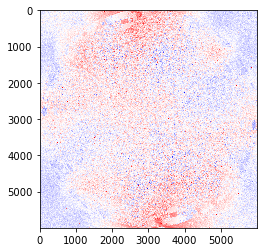

In [11]:
vmax = np.percentile(np.abs(test_data[1][0][0] - test_data[0][0][0]), (90))
vmin = -vmax
plt.imshow(test_data[1][0][0] - np_denoised[0][0], cmap='bwr', vmin=vmin, vmax=vmax, origin='upper', interpolation='none')

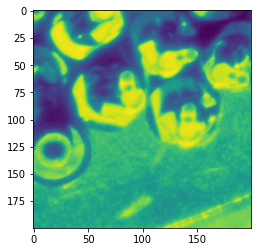

In [12]:
plt.imshow(np_denoised[0][0][5500:5700, 3900:4100])

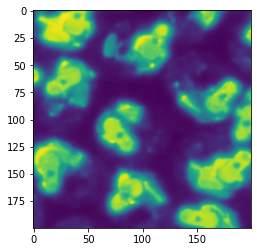

In [15]:
plt.imshow(np_denoised[0][0][1500:1700, 3900:4100])

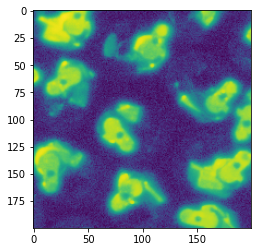

In [16]:
plt.imshow(samp_6k[0][0][1500:1700, 3900:4100])

IndexError: index 1 is out of bounds for axis 0 with size 1

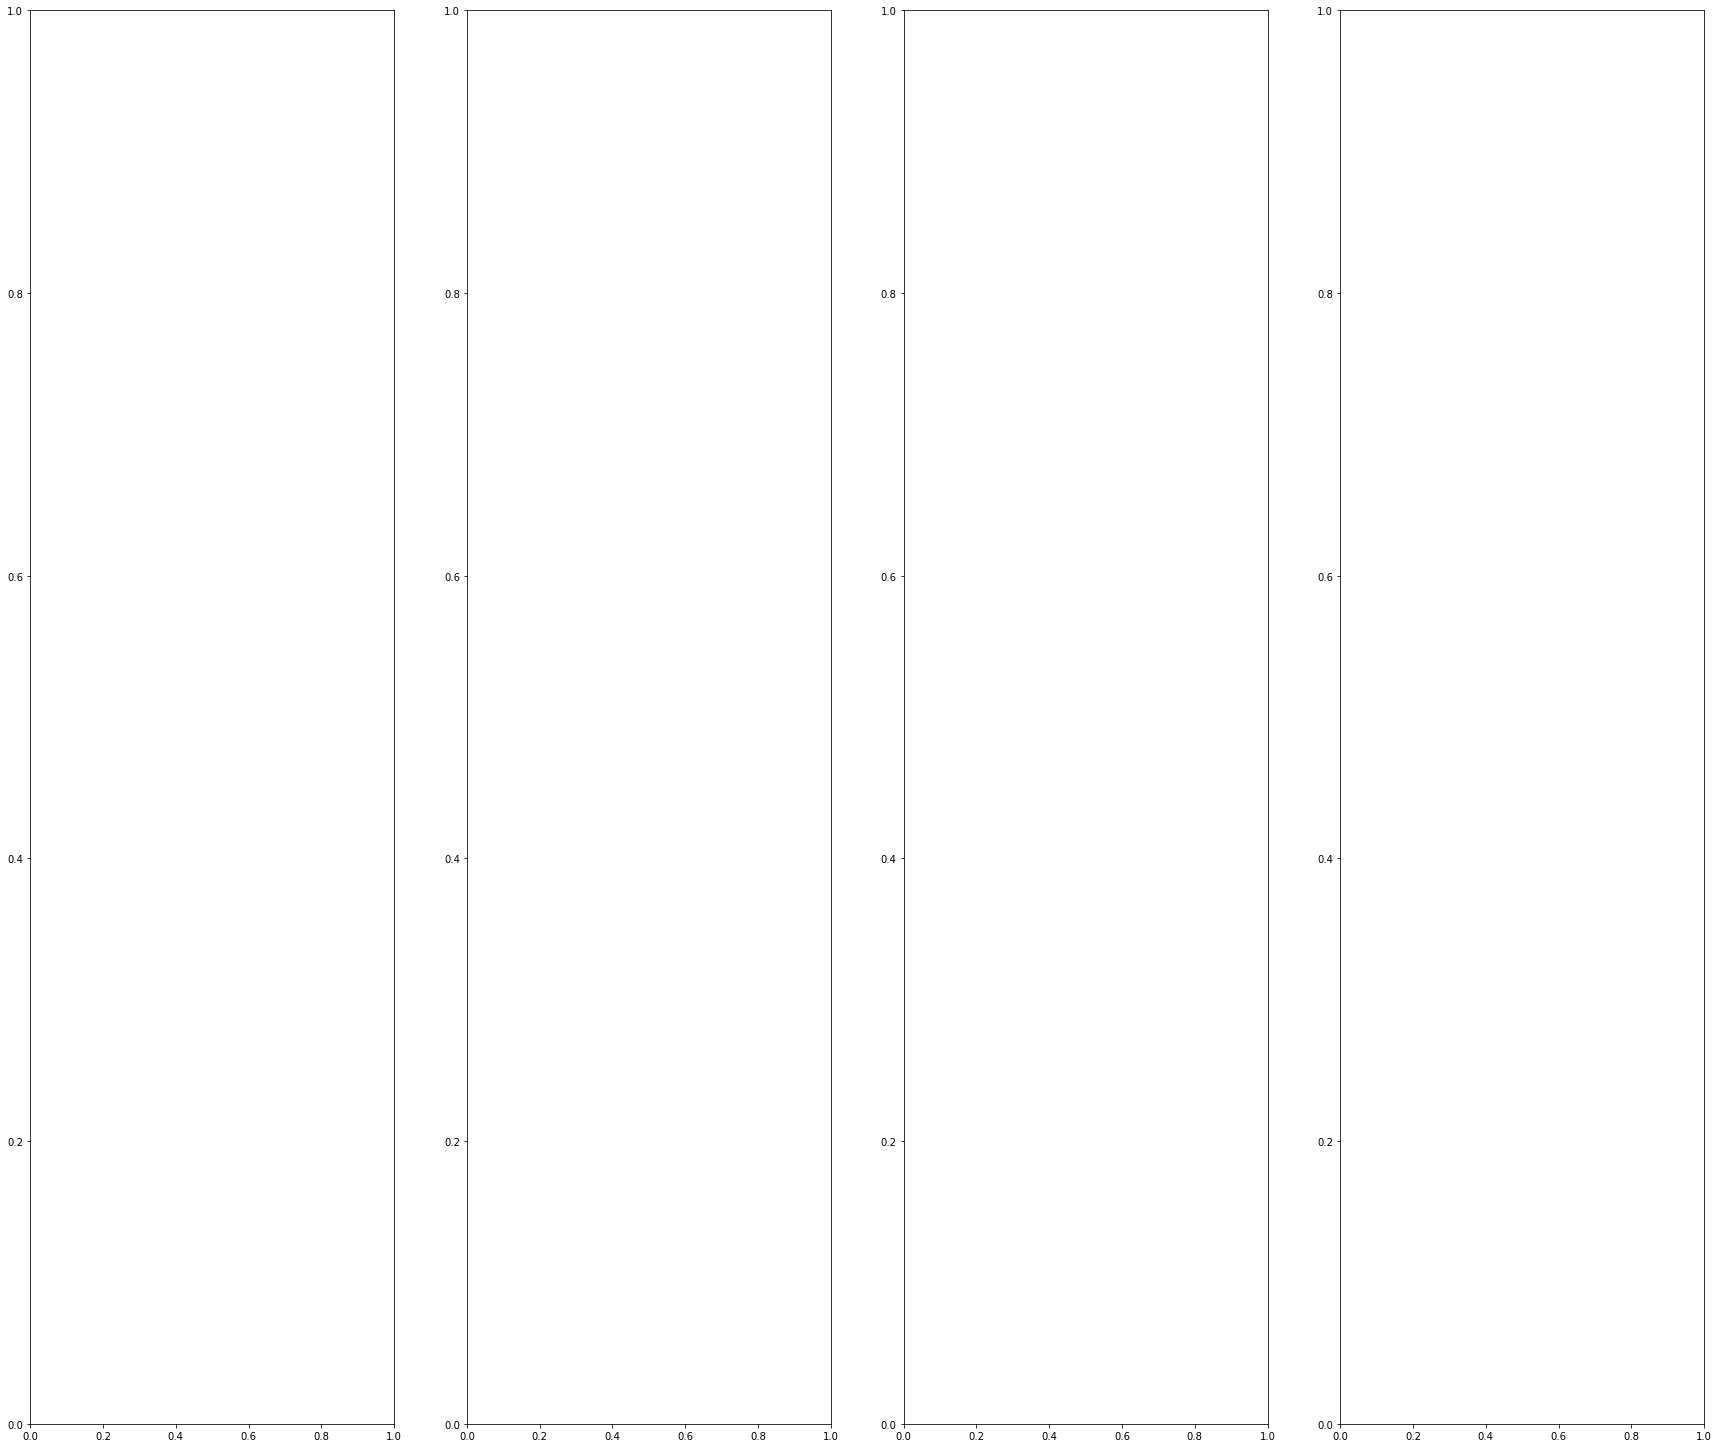

In [18]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k_raw = raw_data[0][0][start_idx:end_idx, start_idx:end_idx]
    # data_6k_truth = raw_data[1][0][start_idx:end_idx, start_idx:end_idx]

    full_img_inf = inf_data[0][0][start_idx:end_idx, start_idx:end_idx]
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 4,figsize=(30, 26))
    # For full focalplane image
    vmin_full, vmax_full = np.percentile(raw_data[0][0], (1, 99)) 
    # For sub-images
    vmin, vmax = np.percentile(data_6k_raw, (1,99))
    # For residuals    
    vmax = np.percentile(np.abs(raw_data[1][0][0] - raw_data[0][0][0]), (90))
    vmin = -vmax

    # NOTE: to display the FP in the correct orientation origin='upper',
    # while usually I set it to 'lower'. 
    # Ask David/figure out why this is.
    ax[0].imshow(raw_data[0][0], vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy',fontsize=30) 
    ax[2].imshow(full_img_inf - data_6k_raw, cmap='bwr', vmin=vmin_resid, vmax=vmax_resid, origin='upper', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Noisy-Denoised Residual', fontsize=30)
    ax[3].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Denoised',fontsize=30) 
    # ax[4].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    # ax[4].axis('off')
    # ax[4].set_title('Truth', fontsize=30)
    
plot_comparison(raw_data=samp_6k,
                inf_data=np_denoised,
                size=200,
                start_idx=1400,
                end_idx=1600)

In [ ]:
def plot_comparison_full(raw_data, inf_data):
    
    data_6k_raw = raw_data[0][0]
    full_img_inf = inf_data[0][0]
    

    
    
    fig, ax = plt.subplots(1, 2,figsize=(30, 26))
    # For full focalplane image
    vmin_full, vmax_full = np.percentile(raw_data[0][0], (1, 99)) 

    # NOTE: to display the FP in the correct orientation origin='upper',
    ax[0].imshow(raw_data[0][0], vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(full_img_inf, vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Numpy Denoised Image', fontsize=30)
    
plot_comparison_full(raw_data=samp_6k, inf_data=np_denoised)